In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
import elo_tools as et
from glob import glob
from tqdm import tqdm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

random_error_rate = 0.5

# Function definitions

In [2]:
def win_count_by_rank_difference(path):
    
    df = pd.read_excel(path)

    delta_rank = df['cage 2 rank'] - df['cage 1 rank']
    outcome = df['winner cage'] == 1

    deltas = np.unique(delta_rank)

    win_prob = []
    win_num = []
    loss_num = []
    expected = []

    for delta in deltas:
        trials = outcome[np.where(delta_rank == delta)[0]]
        num_trials = len(trials)
        wins = trials.sum()
        losses = num_trials - wins

        win_prob.append(wins/num_trials * 100)
        win_num.append(wins)
        loss_num.append(losses)

        if delta < 0:
            expected.append(0)
        elif delta > 0:
            expected.append(num_trials)
        else:
            expected.append(num_trials / 2)

    win_prob = (np.flip(100 - np.array(win_prob)) + win_prob) / 2
    
    # Calculate number of wins per delta rank
    loss_num.reverse()
    win_num = np.array(win_num)
    loss_num = np.array(loss_num)
    win_num = win_num + loss_num
    
    return deltas, win_num, win_prob

# Ingroup error rate

In [6]:
error_deltas = []
ingroup_distribution = []

path = 'Data/behaviour/raw/'
files = glob(f'{path}*.xls')

win_prob = {-3: [],
            -2: [],
            -1: [],
            0: [],
            1: [],
            2: [],
            3: []}

for file in tqdm(files):
    ratings, ranks, C, S, T, dates= et.process_group_elo(file, plotting=False)

    df = pd.read_excel(file)

    dates = np.unique(df.Date)

    for n, date in enumerate(dates):

        window = df[df.Date == date]
        day_ranks = dict(pd.DataFrame(ranks).loc[n])
        winner_ranks = window.Winner.replace(day_ranks)
        loser_ranks = window.Loser.replace(day_ranks)

        rank_delta = winner_ranks - loser_ranks
        ingroup_distribution.append(rank_delta)
        
        for delta in [-1, -2, -3]:
            errors = (rank_delta == delta).sum()
            total = (np.abs(rank_delta) == -delta).sum()
            
            
            if total == 0:
                continue
            win_prob[delta].append(errors / total)
            win_prob[-delta].append((total - errors) / total)

        if (rank_delta < 0).sum() < 1:
            continue
        else:
            error_deltas.append(np.array(rank_delta[rank_delta < 0]))

        #total.append(window.shape[0])

ingroup_distribution = np.concatenate(ingroup_distribution)
ingroup_distribution = ingroup_distribution[np.isin(ingroup_distribution, np.arange(-3, 4))]
ingroup_distribution = ingroup_distribution[ingroup_distribution != 0]
ingroup_win_num = np.histogram(ingroup_distribution, bins=np.arange(-3,5))
error_deltas = np.concatenate(error_deltas)
#total = np.sum(total)

ingroup_win_prob = []

for v in win_prob.values():
    ingroup_win_prob.append(np.mean(v))
    
ingroup_win_prob[3] = 0.5
ingroup_win_prob = np.array(ingroup_win_prob) * 100

  0%|          | 0/46 [00:00<?, ?it/s]/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/166658547.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  winner_ranks = window.Winner.replace(day_ranks)
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/166658547.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loser_ranks = window.Loser.replace(day_ranks)
  2%|▏         | 1/46 [00:00<00:28,  1.56it/s]/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/166658547.py:26: FutureWarning: Downcast

In [14]:
print("Ingroup error rate:")
print(f"{round((ingroup_distribution < 0).sum() / len(ingroup_distribution) * 100, 2)}%")

Ingroup error rate:
18.68%


# Main

## Winner-loser rank differences

In [67]:
condition = 'NMDA+methimazole'

intervention_path = f'Data/behaviour/generalization/{condition}.xlsx'

int_deltas, int_win_num, int_win_prob = win_count_by_rank_difference(intervention_path)
int_num_errors = int_win_num[int_deltas < 0].sum()
int_total = int_win_num.sum()

### Stats test
binom_result = stats.binomtest(int_num_errors, int_total, random_error_rate, alternative='less')
binom_result

BinomTestResult(k=10, n=25, alternative='less', statistic=0.4, pvalue=0.21217811107635498)

In [68]:
int_distribution = []

df = pd.read_excel(intervention_path)

for cage in [1,2]:
    
    other = (np.array([1,2])[np.array([1,2]) != cage])[0]
    
    subset = df[df['winner cage'] == cage]
    
    rank_delta = subset[f'cage {cage} rank'] - subset[f'cage {other} rank']
    
    int_distribution.append(rank_delta * -1)
    
int_distribution = np.concatenate(int_distribution)
int_distribution = int_distribution[int_distribution != 0]

print(len(int_distribution))
print(len(ingroup_distribution))

# Stats test
MWresult = stats.mannwhitneyu(int_distribution, ingroup_distribution, alternative='less')
MWresult

24
2773


MannwhitneyuResult(statistic=np.float64(25253.5), pvalue=np.float64(0.01644316715282565))

Text(0, 100, '*')

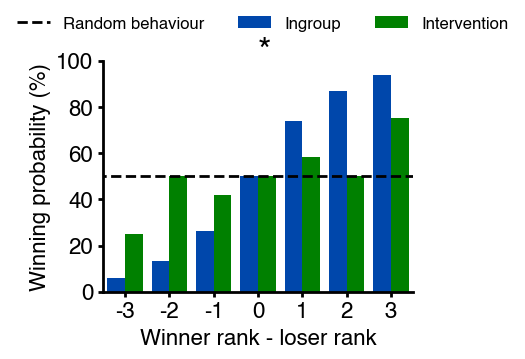

In [69]:
# Limit the control dataset to rank deltas observed in the intervention dataset
ingroup_deltas = np.arange(-3, 4)
overlapping_deltas = np.isin(ingroup_deltas, int_deltas)
ingroup_deltas[overlapping_deltas]
ingroup_win_prob[overlapping_deltas]

fig, ax = plt.subplots(figsize=[4,3])

offset = 0.2

plt.bar(ingroup_deltas - offset, ingroup_win_prob, width=offset*2, color='#0047AB', label='Ingroup')
plt.bar(int_deltas + offset, int_win_prob, width=offset*2, color='green', label='Intervention')
plt.ylabel('Winning probability (%)')
plt.xlabel('Winner rank - loser rank')

plt.ylim(0,100)
plt.xlim(min(int_deltas) - 0.5, max(int_deltas) + 0.5)
plt.xticks(ticks=int_deltas, labels=int_deltas)

plt.plot(np.arange(-5,5), np.ones(10)*50, linestyle='--', c='black', label='Random behaviour')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(prop={'size': 12}, loc=[-0.3,1.1], ncol=3, frameon=False)

p = MWresult.pvalue
sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()]
if sig_label == 'n.s.':
    fontsize = 20
else:
    fontsize = 25
plt.text(0, 100, sig_label, fontsize=fontsize)

#plt.savefig(f'../Plots/Generalization/{condition}.png', bbox_inches='tight', dpi=300)

## Error rates across conditions

In [70]:
paths = ['Data/behaviour/generalization/Control.xlsx',
        'Data/behaviour/generalization/Darkness.xlsx',
        'Data/behaviour/generalization/NMDA+methimazole.xlsx',
        'Data/behaviour/generalization/Methimazole.xlsx',
        'Data/behaviour/generalization/NMDA.xlsx',
        'Data/behaviour/generalization/Castration.xlsx',
        ]

nice_names = {'Control': 'Intact',
              'Darkness': 'Darkness',
              'NMDA+methimazole': 'MMZ+NMDA',
              'Methimazole': 'MMZ',
              'NMDA': 'NMDA',
              'Castration': 'Castration'}

pvals_binom = []
pvals_U = []
error_rates = []
names = []

errors = {}
trials = {}
distributions = {}
win_probabilities = {}
for intervention_path in paths:
    
    name = intervention_path.split('/')[-1].split('.')[0]
    name = nice_names[name]
    names.append(name)

    int_deltas, int_win_num, int_win_prob = win_count_by_rank_difference(intervention_path)
    win_probabilities[name] = pd.DataFrame(dict(zip(['delta_rank', 'win_prob'], [int_deltas, int_win_prob])))
    int_num_errors = int_win_num[int_deltas < 0].sum()
    int_total = int_win_num.sum()

    print(name, f'N = {sum(int_win_num)} tube tests')
    
    error_rates.append(int_num_errors / int_total * 100)

    errors[name] = int_num_errors
    trials[name] = int_total

    ### Binomial test
    binom_result = stats.binomtest(int_num_errors, int_total, random_error_rate, alternative='less')
    pvals_binom.append(binom_result.pvalue)
    
    int_distribution = []

    df = pd.read_excel(intervention_path)

    for cage in [1,2]:

        other = (np.array([1,2])[np.array([1,2]) != cage])[0]

        subset = df[df['winner cage'] == cage]

        rank_delta = subset[f'cage {cage} rank'] - subset[f'cage {other} rank']

        int_distribution.append(rank_delta * -1)

    int_distribution = np.concatenate(int_distribution)
    int_distribution = int_distribution[int_distribution != 0]
    distributions[name] = int_distribution

_, pvals_binom_corrected, _, _ = multipletests(pvals_binom, method='holm-sidak')
    
result = pd.DataFrame(np.stack([names, error_rates, pvals_binom_corrected]).T, columns=['condition', 'error_rate', 'pval'])
result.error_rate = pd.to_numeric(result.error_rate)

Intact N = 34 tube tests
Darkness N = 22 tube tests
MMZ+NMDA N = 25 tube tests
MMZ N = 32 tube tests
NMDA N = 25 tube tests
Castration N = 9 tube tests


In [71]:
control = 'MMZ+NMDA'
intervention = 'Darkness'

count = [errors[condition] for condition in [control, intervention]]
nobs = [trials[condition] for condition in [control, intervention]]

from statsmodels.stats.proportion import proportions_ztest
z, p = proportions_ztest(count, nobs)
pvals_binom.append(p)

In [72]:
_, pvals_binom_corrected, _, _ = multipletests(pvals_binom, method='holm-sidak')

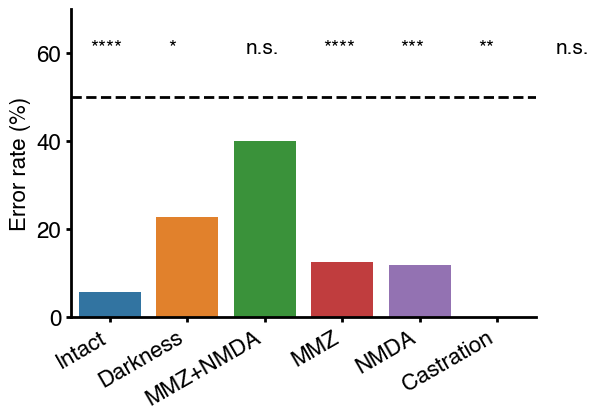

In [73]:
plt.figure(figsize=[6, 4])

sns.barplot(result, x='condition', y='error_rate', hue='condition')
plt.xticks(rotation=30, ha='right')

plt.ylabel('Error rate (%)')
plt.xlabel('')

plt.ylim(0,70)
plt.axhline(50, c='black', linestyle='--', label='Random behaviour')

for n, p in enumerate(pvals_binom_corrected):
    sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()]
    plt.text(n-0.25, 60, sig_label, fontsize=15)
    
#plt.savefig('../Plots/Generalization/Error rate.png', bbox_inches='tight', dpi=300)

## Spontaneous rank changes

### Error rate

In [74]:
data = pd.read_csv('Data/hierarchy perturbation experiments/Spontaneous_rank_switches.csv')
data = data.dropna(axis=0)
data.testing_day = data.testing_day.astype(str)

# Identify which trials have erroneous outcomes
data['rank_delta'] = data.loser_rank - data.winner_rank
data['error'] = data.rank_delta < 0

# Determine the error rate per mouse on each testing day
errors_per_mouse = []
errors_per_mouse.append(data[['testing_day', 'mouse_1_id', 'error']].groupby(['testing_day', 'mouse_1_id']).sum() / data[['testing_day', 'mouse_1_id', 'error']].groupby(['testing_day', 'mouse_1_id']).count() * 100)
errors_per_mouse.append(data[['testing_day', 'mouse_2_id', 'error']].groupby(['testing_day', 'mouse_2_id']).sum() / data[['testing_day', 'mouse_2_id', 'error']].groupby(['testing_day', 'mouse_2_id']).count() * 100)
errors_per_mouse = pd.concat(errors_per_mouse)
errors_per_mouse.reset_index(inplace=True)
errors_per_mouse = errors_per_mouse.rename(columns={'level_1': 'mouse_id'})

# Identify the mice whose ranks have changed across testing days
switchers = []
for cage in ['1', '2']:
    ingroup_ranks = data[['testing_day', f'mouse_{cage}_id', f'cage_{cage}_rank']].groupby(['testing_day', f'mouse_{cage}_id']).median()
    switchers.append((ingroup_ranks.loc['1.0'] != ingroup_ranks.loc['2.0']).reset_index().rename(columns={f'mouse_{cage}_id': 'mouse_id',
                                                                                                f'cage_{cage}_rank': 'switcher'}))
    
switchers = pd.concat(switchers)

errors_per_mouse = pd.merge(errors_per_mouse, switchers, on='mouse_id', how='left')

data =   pd.merge(data, 
         switchers.rename(columns={'mouse_id': 'mouse_1_id'}), 
         on='mouse_1_id').rename(columns={'switcher': 'switcher1'})
data =   pd.merge(data, 
         switchers.rename(columns={'mouse_id': 'mouse_2_id'}), 
         on='mouse_2_id').rename(columns={'switcher': 'switcher2'})

data['switcher'] = data.switcher1 | data.switcher2
data = data.drop(['switcher1', 'switcher2'], axis=1)

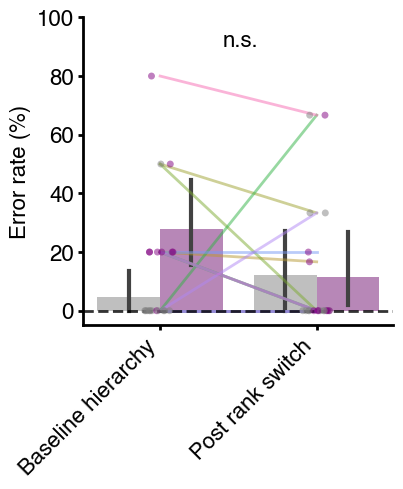

In [75]:
plt.figure(figsize=[4,4])

palette = {True: 'purple',
           False: 'grey'}

sns.barplot(errors_per_mouse, x='testing_day', y='error', hue='switcher', palette=palette,  alpha=0.5)
sns.stripplot(errors_per_mouse, x='testing_day', y='error', hue='switcher', palette=palette, alpha=0.5, dodge=False)
sns.lineplot(errors_per_mouse, x='testing_day', y='error', hue='mouse_id', color='black', alpha=0.5)

plt.ylabel('Error rate (%)')
plt.ylim(-5,100)

plt.xlabel('')
plt.xticks([0,1], ['Baseline hierarchy', 'Post rank switch'], rotation=45, ha='right')

plt.axhline(0, linestyle='--', alpha=0.8, color='black')
plt.text(0.4, 90, 'n.s.')

plt.legend('', frameon=False)

#plt.savefig('../Plots/Generalization/spontaneous_rank_change.png', dpi=300, bbox_inches='tight')

In [76]:
import statsmodels.formula.api as smf
import statsmodels.api as sm 

model = smf.ols('error ~ testing_day + switcher + mouse_id', errors_per_mouse).fit()
sm.stats.anova_lm(model, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
testing_day,1.0,100.277778,100.277778,0.444706,0.511794
switcher,1.0,1263.302469,1263.302469,5.602416,0.027154
mouse_id,16.0,12474.358176,779.647386,3.457533,0.003872
Residual,22.0,4960.833333,225.492424,NaN,NaN


### Winner-loser delta rank

In [77]:
only_switchers = True

if only_switchers:
    data = data[data.switcher]

# Find the frequency of wins for each delta rank
win_prob = data[['date', 'testing_day', 'rank_delta']].groupby(['testing_day', 'rank_delta']).count().reset_index()
win_prob = win_prob.rename(columns={'date': 'frequency'})
win_prob['abs_rank_delta'] = win_prob.rank_delta.abs()

# Find the total number of trials for each delta rank
total_trials = data[['testing_day', 'rank_delta']]
total_trials['abs_rank_delta'] = total_trials.rank_delta.abs().astype(int)
total_trials = total_trials.groupby(['testing_day', 'abs_rank_delta']).count().reset_index()
total_trials = total_trials.rename(columns={'rank_delta': 'total_trials'})

# Obtain the winning probability for each delta rank
win_prob = pd.merge(win_prob, total_trials, on=['testing_day', 'abs_rank_delta'])
win_prob['win_probability'] = win_prob.frequency / win_prob.total_trials * 100

/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/2761813086.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_trials['abs_rank_delta'] = total_trials.rank_delta.abs().astype(int)


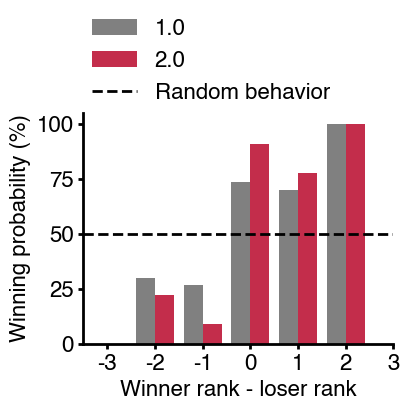

In [78]:
plt.figure(figsize=[4,3])

palette = {'1.0': 'grey',
           '2.0': 'crimson'}

sns.barplot(win_prob, x='rank_delta', y='win_probability', hue='testing_day', palette=palette)
#plt.xticks(np.arange(0, 7), np.arange(-3, 4))

plt.ylabel('Winning probability (%)')
plt.xlabel('Winner rank - loser rank')
plt.xticks(np.arange(-1,6), np.arange(-3,4))
plt.xlim(-1.5)

plt.axhline(50, linestyle='--', color='black', label='Random behavior')

plt.legend(frameon=False, loc=[0,1])
#plt.text(-0.2, 80, 'n.s.')

if only_switchers: 
    suffix = '_only_switchers'
else: suffix = ''

#plt.savefig(f'../Plots/Generalization/Rank_change_win_probs{suffix}.png', dpi=300, bbox_inches='tight')

In [79]:
stats.mannwhitneyu(data[data.testing_day == '1.0'].rank_delta, data[data.testing_day == '2.0'].rank_delta, alternative='greater')

MannwhitneyuResult(statistic=np.float64(304.5), pvalue=np.float64(0.7944946508736577))

## Urine-induced rank change

### Error rate

In [80]:
# Load data
data = pd.read_excel('Data/hierarchy perturbation experiments/Urine-induced rank switch.xlsx')
data = data.dropna(axis=0)

# Calculate the winner-loser rank difference based on assumption of unchanged hierarchy and shifted hierarchy due to urine painting
data['delta_rank_original'] = data.loser_rank_original - data.winner_rank_original
data['delta_rank_switched'] = data.loser_rank_switched - data.winner_rank_switched

data['error_original'] = data['delta_rank_original'] < 0
data['error_switched'] = data['delta_rank_switched'] < 0

error_freq = data[['error_original', 'error_switched']].sum()
error_freq['error_control'] = errors['Intact']

error_rates =  error_freq / data.shape[0] * 100
error_rates['error_control'] = result[result.condition == 'Intact'].error_rate[0]
error_rates = error_rates.reset_index().rename(columns={'index':'condition',
                                          0: 'error_rate'})

trial_num = data[['error_original', 'error_switched']].count()
trial_num['error_control'] = 34
trial_num = trial_num.reset_index().rename(columns={'index':'condition',
                                        0: 'total_trials'})
trial_num = trial_num.set_index('condition')


([<matplotlib.axis.XTick at 0x15f1db4d0>,
 [Text(0, 0, 'Baseline hierarchy'),
  Text(1, 0, 'Rank switch'),
  Text(2, 0, 'Control')])

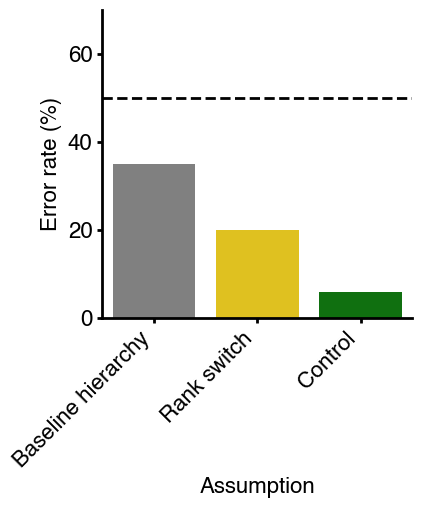

In [81]:
plt.figure(figsize=[4,4])

palette = {'error_original': 'grey',
           'error_switched': '#FFD700',
           'error_control': 'green'}

sns.barplot(error_rates, x='condition', y='error_rate', hue='condition', palette=palette)

plt.xlabel('Assumption')
plt.ylabel('Error rate (%)')

plt.ylim(0,70)
plt.axhline(50, linestyle='--', color='black', label='Random behavior')

plt.xticks([0,1,2], ['Baseline hierarchy', 'Rank switch', 'Control'], rotation=45, ha='right')

#plt.savefig('../Plots/Urine painting/Urine_error_rate.png', dpi=300, bbox_inches='tight')

In [82]:
tests = {}
annotations = []

conditions = list(error_freq.index)
for n, condition1 in enumerate(conditions):
    for m, condition2 in enumerate(conditions[n+1:]):

        _, p = proportions_ztest([error_freq[condition1], error_freq[condition2]], 
                                 [trial_num.loc[condition1][0], trial_num.loc[condition2][0]])
        
        #annotations.append([n, m+n+1, p])
        tests[(condition1, condition2)] = p

    p = stats.binomtest(error_freq[condition1], trial_num.loc[condition1][0], 0.5, alternative='less').pvalue
    tests[(condition1, 'random')] = p

tests = dict(zip(tests.keys(), multipletests(list(tests.values()))[1]))
tests

/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/842270683.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [trial_num.loc[condition1][0], trial_num.loc[condition2][0]])
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_4938/842270683.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = stats.binomtest(error_freq[condition1], trial_num.loc[condition1][0], 0.5, alternative='less').pvalue


{('error_original', 'error_switched'): np.float64(0.2971962442135386),
 ('error_original', 'error_control'): np.float64(0.027501474287357386),
 ('error_original', 'random'): np.float64(0.2971962442135386),
 ('error_switched', 'error_control'): np.float64(0.2971962442135386),
 ('error_switched', 'random'): np.float64(0.027501474287357386),
 ('error_control', 'random'): np.float64(2.0815057737378095e-07)}

### Winner-loser delta rank

In [83]:
# Load data
data = pd.read_excel('Data/hierarchy perturbation experiments/Urine-induced rank switch.xlsx')
data = data.dropna(axis=0)

# Calculate the winner-loser rank difference based on assumption of unchanged hierarchy and shifted hierarchy due to urine painting
data['delta_rank_original'] = data.loser_rank_original - data.winner_rank_original
data['delta_rank_switched'] = data.loser_rank_switched - data.winner_rank_switched

# Obtain winning frequency for each delta rank for both assumptions
original_freqs = data[['delta_rank_original', 'testing_day']].groupby('delta_rank_original').count().reset_index().rename(columns={'testing_day': 'frequency'})
switched_freqs = data[['delta_rank_switched', 'testing_day']].groupby('delta_rank_switched').count().reset_index().rename(columns={'testing_day': 'frequency'})

freqs = pd.concat([original_freqs, switched_freqs])
freqs = freqs.melt( id_vars='frequency',
            value_vars=['delta_rank_original', 'delta_rank_switched', 'frequency'],
            value_name='delta_rank', 
            var_name='assumption').dropna(axis=0)
freqs['abs_rank_delta'] = abs(freqs.delta_rank)

# Obtain the total number of trials for each delta rank for both assumptions
total_trials = freqs.copy()
total_trials = total_trials.groupby(['assumption', 'abs_rank_delta']).sum().reset_index()
total_trials = total_trials[['assumption', 'abs_rank_delta', 'frequency']].rename(columns={'frequency': 'total_trials'})

# Calculate the proportional winning probability for each delta rank for both assumptions
win_prob = pd.merge(freqs, total_trials, on=['assumption', 'abs_rank_delta'], how='left')
win_prob['win_prob'] = win_prob.frequency / win_prob.total_trials * 100
win_prob.assumption = win_prob.assumption.map({'delta_rank_original': 'Baseline hierarchy',
                                               'delta_rank_switched': 'Urine-induced rank switch',})
win_prob.delta_rank = win_prob.delta_rank.astype(int)

# Add control probabilities
win_prob = pd.concat([win_prob, win_probabilities['Intact']])

In [84]:
win_prob.assumption = win_prob.assumption.where(~win_prob.assumption.isnull(), other='Control')

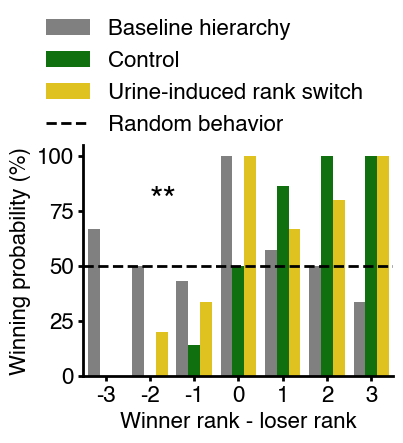

In [85]:
plt.figure(figsize=[4,3])

palette = {'Baseline hierarchy': 'grey',
           'Urine-induced rank switch': '#FFD700',
           'Control': 'green'}

sns.barplot(win_prob, x='delta_rank', y='win_prob', hue='assumption', palette=palette)
plt.axhline(50, linestyle='--', color='black', label='Random behavior')

plt.ylabel('Winning probability (%)')
plt.xlabel('Winner rank - loser rank')
plt.xlim(-0.5, 6.5)

plt.text(1, 75, '**', fontsize=25)

plt.legend(frameon=False, loc=[-0.15,1], ncol=1)

#plt.savefig('../Plots/Urine painting/Urine-induced rank change generalization.png', dpi=300, bbox_inches='tight')

In [86]:
stats.mannwhitneyu(data[data.delta_rank_original != 0.].delta_rank_original,
                   distributions['Intact'])

MannwhitneyuResult(statistic=np.float64(104.5), pvalue=np.float64(0.005764157282323051))

In [87]:
stats.mannwhitneyu(data[data.delta_rank_switched != 0.].delta_rank_switched,
                   distributions['Intact'])

MannwhitneyuResult(statistic=np.float64(161.5), pvalue=np.float64(0.1081216603840425))

## Changes in snout-to-snout time

In [88]:
from path import Path
import snebeat.behav_tools as bat

fps = {'Preablation': 30,
    'MMZpostinjection': 40,
    'postNMDA': 30,
    'postNMDA+methimazole': 30,
    'postNMDA+methimazole2': 30
    }

nice_names = dict(zip(['Preablation', 'postNMDA', 'MMZpostinjection', 'postNMDA+methimazole', 'postNMDA+methimazole2'],
                       ['Intact', 'NMDA', 'MMZ', 'MMZ+NMDA', 'MMZ+NMDA']))

path = 'Data/Tube test initial chemoinvestigation/'
files = glob(path)

results = []
for condition in fps.keys():
    file = ''.join([path, condition, '_No focal subject.csv'])
    dataset = pd.read_csv(file)

    segments, _ = bat.segment(dataset, state_ref='sniff')
    lengths = [segment.shape[0] / fps[condition] for segment in segments]

    df = pd.DataFrame(np.vstack([lengths, [nice_names[condition]] * len(lengths)]).T, columns=['length', 'condition'])
    results.append(df)
    
results = pd.concat(results) 
results.length = results.length.astype(float)
results['log_length'] = np.log(results.length)

/Users/borakn/opt/anaconda3/envs/HierarchySensoryModality/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


([0, 1, 2, 3],
 [Text(0, 0, 'Intact'),
  Text(1, 0, 'MMZ'),
  Text(2, 0, 'NMDA'),
  Text(3, 0, 'MMZ+NMDA')])

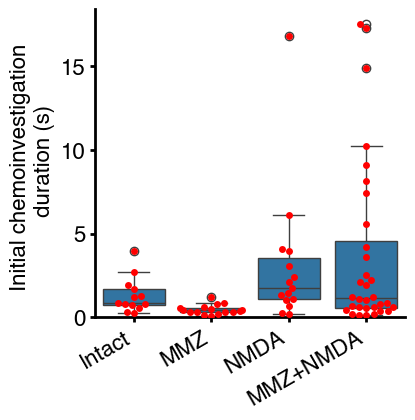

In [89]:
y = 'length'

plt.figure(figsize=[4,4])

sns.boxplot(results, x='condition', y=y)
sns.swarmplot(results, x='condition', y=y, color='red')

plt.ylabel('Initial chemoinvestigation \n duration (s)')
plt.xlabel('')
plt.ylim(0)
plt.xticks(rotation=30, ha='right')

#plt.savefig('../Plots/Generalization/snout-to-snout time.png', dpi=300, bbox_inches='tight')

### Parametric test of the log durations

In [90]:
Ps = {}
for pair in zip(['Intact', 'Intact', 'Intact'], 
                ['MMZ', 'NMDA', 'MMZ+NMDA']):

    control, treatment = pair
    t, p = ttest_ind((results[results.condition == control][y]),
                    (results[results.condition == treatment][y]))
    
    Ps[pair] = p

multipletests(list(Ps.values()))

(array([ True, False, False]),
 array([0.01252167, 0.19768551, 0.19768551]),
 np.float64(0.016952427508441503),
 0.016666666666666666)

### Skewness test

In [91]:
from scipy.stats import skewtest

conditions = ['Intact', 'MMZ', 'NMDA', 'MMZ+NMDA']

n_bootstrap = 30

skewness_result = {condition: [] for condition in conditions}
for condition in conditions:
    data = results[results['condition'] == condition].length
    n = data.shape[0]

    for _ in range(n_bootstrap):
        # Generate a bootstrap sample
        sample = np.random.choice(data, size=n, replace=True)
        
        # Perform skewness test on the bootstrap sample
        skew_stat, _ = skewtest(sample)
        
        # Store the result
        skewness_result[condition].append(skew_stat)

skewness_result = pd.DataFrame(skewness_result)
skewness_result = skewness_result.melt(value_vars = conditions, var_name='condition', value_name='skewness')

<Axes: xlabel='condition', ylabel='skewness'>

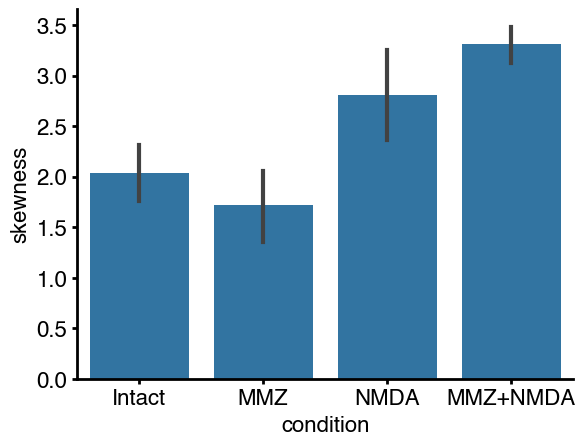

In [92]:
sns.barplot(skewness_result, x='condition', y='skewness')
#sns.stripplot(skewness_result, x='condition', y='skewness')

In [93]:
Ps = {}
for pair in zip(['Intact', 'Intact', 'Intact'], 
                ['MMZ', 'NMDA', 'MMZ+NMDA']):

    control, treatment = pair
    t, p = ttest_ind((skewness_result[skewness_result.condition == control].skewness),
                    (skewness_result[skewness_result.condition == treatment].skewness))
    
    Ps[pair] = p

Ps = dict(zip(Ps.keys(), multipletests(list(Ps.values()))[1]))
Ps

{('Intact', 'MMZ'): np.float64(0.19748401299250629),
 ('Intact', 'NMDA'): np.float64(0.009585009075706816),
 ('Intact', 'MMZ+NMDA'): np.float64(3.138960245590166e-09)}

### Non-parametric test

In [94]:
from scipy.stats import kruskal

kruskal(*[results[results.condition == condition][y] for condition in ['Intact', 'MMZ', 'NMDA', 'MMZ+NMDA']])

import scikit_posthocs as sp

# Conduct Dunn's test
posthoc = sp.posthoc_dunn(results, 
                          val_col='length', 
                          group_col='condition', 
                          p_adjust='holm-sidak')
print(posthoc)

            Intact       MMZ  MMZ+NMDA      NMDA
Intact    1.000000  0.062569  0.696850  0.618705
MMZ       0.062569  1.000000  0.002194  0.001551
MMZ+NMDA  0.696850  0.002194  1.000000  0.696850
NMDA      0.618705  0.001551  0.696850  1.000000
